**Step 0 - install and import dependencies**

In [ ]:
!pip install pythainlp
!pip install tensorflow_text
!pip install umap-learn

     |████████████████████████████████| 11.0 MB 7.0 MB/s 
     |████████████████████████████████| 743 kB 47.0 MB/s 
     |████████████████████████████████| 4.9 MB 6.8 MB/s 
     |████████████████████████████████| 86 kB 4.2 MB/s 
     |████████████████████████████████| 1.1 MB 31.8 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82709 sha256=866589f7552acb9ed8d359bd55d0d139a78f6d031e4b5c3c35d6bdebdf15763b
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52603 sha256=0c9b31c7e94a4efab212bb7ecab5609f9afaea640c917a91c8c3ab25eac97134
  Stored in directory: /root/.cache/pip/wheels/af/e9/33/04db1436df0757c42fda8ea6796d7a8586e23c85fac355f476
Successfully built umap-learn pynndescent


In [ ]:
import numpy as np
import pandas as pd
import re

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import umap

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

import pythainlp
from pythainlp.corpus.common import thai_words
from pythainlp.util import Trie
import collections


In [ ]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' #'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' for a large model

model = hub.load(module_url)

In [ ]:
df = pd.read_csv("Wongnai Reviews - Small.csv")

In [ ]:
df.head()

,Review ID,Review
0,1,เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีวันนึงเด...
1,2,Art of Coffee Kasetsart เป็นร้านกาแฟรสชาติเยี่...
2,3,กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่ค...
3,4,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...
4,5,ชอบมาทานร้านนี้ถ้าอยากกินอาหารเวียดนามใกล้บ้าน...


**Step 1 - document embedding and dimension reduction**

In [ ]:
#embed sentences using Universal Sentence Encoder (USE)

embed_comments_array = model(df['Review'].values).numpy()
embed_comments_array

array([[ 0.08993827,  0.01941084,  0.03787038, ..., -0.03488849,
         0.06299512,  0.04635989],
       [ 0.00634244,  0.00814594,  0.03071941, ..., -0.01478723,
        -0.03080936, -0.03316405],
       [ 0.0633687 , -0.02027139, -0.05077003, ..., -0.06530775,
        -0.00952999, -0.03439987],
       ...,
       [ 0.08775924,  0.03609736,  0.01263062, ..., -0.03102781,
        -0.03361677,  0.01928871],
       [ 0.05691195,  0.05381691, -0.0399575 , ..., -0.06598807,
        -0.05390478, -0.01037725],
       [ 0.0777048 ,  0.05080631,  0.02680681, ..., -0.0061413 ,
        -0.01313567,  0.02236264]], dtype=float32)

In [ ]:
#reduce array dimensions using umap (you can chagne n_components)

reducer = umap.UMAP(random_state=42,n_components=50)
umap_embed_comments_array = reducer.fit_transform(embed_comments_array)

**Step 2 - document clustering using KMeans**

Text(0, 0.5, 'WCSS')

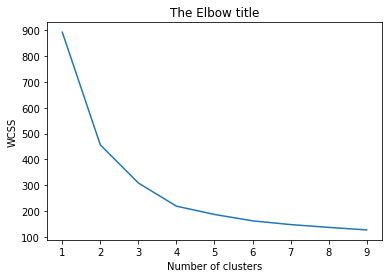

In [ ]:
#run kmeans with various number of k. evaluate no. of k based on the elbow plot

wcss=[]
max_k = 10
for i in range(1, max_k):
  kmeans = KMeans(i)
  kmeans.fit(umap_embed_comments_array)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1, max_k)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [ ]:
#run kmeans with no. of clusters you see fit the most

k = 3

kmeans = KMeans(n_clusters = k)
kmeans.fit(umap_embed_comments_array)

df['KMeans ID'] = kmeans.labels_

In [ ]:
#merge all reviews of each cluster into one big sentence 

df_kmeans = pd.DataFrame(columns=["KMeans ID", "texts"])


for i in range(0, k):
  row = []
  row.append(i)
  row.append(df['Review'][df['KMeans ID'] == i].to_string())
  df_kmeans.loc[len(df_kmeans)] = row

In [ ]:
df_kmeans

,KMeans ID,texts
0,0,0 เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีว...
1,1,2 กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูห...
2,2,13 เคยเป็นไหมกันไหมคะ หลังอาหารมื้อใหญ่ ต่...


In [ ]:
#create regex compiler for removal of a character you don't want

special_characters = "/[!@#$%^&*']/g"

specialchar_pattern = re.compile(special_characters)

In [ ]:
#create regex compiler for removal of any emoji

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

In [ ]:
#create regex compiler for removal of digit

number_pattern = re.compile("[0-9]")

In [ ]:
#create regex compiler for removal of white space

space_pattern = re.compile("\s+")

In [ ]:
#create regex compiler for removal of .

dot_pattern = re.compile(r"\.+")

In [ ]:
#create regex compiler for removal of \

backslash_pattern = re.compile(r"\\+")

In [ ]:
#define a function to tokenize a sentence into words - you can define words you want to remove as well as new words for tokenization

stopwords = list(pythainlp.corpus.thai_stopwords())
removed_words = ['u', 'b', 'n', 'nn', 'nn-', '\n', 'ร้าน', 'กก', 'สวัสดี', 'ทาน', 'กิน', 'นึง', 'เด', ':', 'ร้า', 'มีโอกาส', 'ไหม', 'แวะ', 'อ', 'กร้าน'
, 'ลอง', 'ผม', 'บ้าน', 'นขา', 'นอ', 'นิว',"ดิชั้น","ดิ","โถม", 'ร้านอาหาร', 'ร้านกาแฟ']
screening_words = stopwords + removed_words

new_words = {"สตารบัก","อเมซอน","อะเมซอน"}

words = new_words.union(thai_words())

custom_dictionary_trie = Trie(words)

def tokenize_to_list(sentence):
  merged = []
  words = pythainlp.word_tokenize(str(sentence), engine='newmm', custom_dict=custom_dictionary_trie)
  for word in words:
    if word not in screening_words:
      merged.append(word)
  return merged

In [ ]:
#clean and tokenize sentences. count the occurences of each word

df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_kmeans['texts_tokenized'] = df_kmeans['texts'].apply(lambda x: tokenize_to_list(x))
df_kmeans['texts_count'] = df_kmeans['texts_tokenized'].apply(lambda x: collections.Counter(x).most_common())

In [ ]:
#results of tokenization

df_kmeans

,KMeans ID,texts,texts_tokenized,texts_count
0,0,เป็นคนที่ชอบทานMacchiatoเป็นประจำมีวันนึงเดArt...,"[คน, ชอบ, Macchiato, เป็นประจำ, ArtofCoffeeKas...","[(กาแฟ, 22), (ชอบ, 9), (คาเฟ่, 6), (น, 6), (ดี..."
1,1,กวงทะเลเผาอาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่คว...,"[กวง, ทะเล, เผา, อาหารทะเล, เค้า, สด, เนื้อ, ป...","[(อร่อย, 11), (อาหาร, 10), (รีวิว, 8), (ส้มตำ,..."
2,2,เคยเป็นไหมกันไหมคะหลังอาหารมื้อใหญ่ต่อให้อิ่เช...,"[หลังอาหาร, มื้อ, ต่อให้, อิ่, เช้า, บ่าย, เย็...","[(ชา, 18), (นม, 14), (ไข่มุก, 14), (เครื่องดื่..."


In [ ]:
#show top keywords of each cluster

top_N_words = 20

for i in range(0, len(df_kmeans)):
  print(f"Cluster ID : {i}\n")
  print(f"Most common words include : {list(df_kmeans['texts_count'][i])[:top_N_words]}\n")

#tune a model by remove unwanted characters and words and add more words to a custom dictionary

Cluster ID : 0

Most common words include : [('กาแฟ', 22), ('ชอบ', 9), ('คาเฟ่', 6), ('น', 6), ('ดี', 6), ('รี่', 5), ('อร่อย', 5), ('กา', 5), ('น่ารัก', 5), ('นั่ง', 5), ('เจอ', 5), ('หา', 5), ('คน', 4), ('เบเกอรี่', 4), ('พาย', 4), ('วัง', 4), ('แนว', 4), ('แถว', 4), ('อเมซอน', 4), ('ซื้อ', 4)]

Cluster ID : 1

Most common words include : [('อร่อย', 11), ('อาหาร', 10), ('รีวิว', 8), ('ส้มตำ', 6), ('ซอย', 6), ('สาขา', 6), ('กาแฟ', 6), ('เพื่อน', 5), ('ไทย', 5), ('เมนู', 5), ('ถนน', 4), ('ราคา', 4), ('แซ่บ', 4), ('คน', 4), ('รอบ', 4), ('บอ', 4), ('เวลา', 4), ('ค', 4), ('รสชาติ', 4), ('ครั้งแรก', 4)]

Cluster ID : 2

Most common words include : [('ชา', 18), ('นม', 14), ('ไข่มุก', 14), ('เครื่องดื่ม', 4), ('รีวิว', 4), ('น้ำ', 3), ('ตั้งอยู่', 3), ('เดิน', 3), ('ปั่น', 3), ('ไต้หวัน', 3), ('เติม', 2), ('ชาเขียว', 2), ('คุง', 2), ('เจอ', 2), ('ขาย', 2), ('Ochaya', 2), ('Aprilstore', 2), ('สยาม', 2), ('คน', 2), ('ของหวาน', 2)]



**Step 4 - result discussion**

ใช้ K-Mean 3 Cluster แทนที่จะเป็น 4 เพราะ 4 มัน Cluster ที่ปนกันจนอธิบายไม่ได้

Cluster 0 : ร้านคาเฟ่ประเภทตามสถานที่ท่องเที่ยว วิวสวยๆ ดูจากคำว่า "กาแฟ","คาเฟ่","เบเกอรี่","นั่ง","วัง","แนว","แถว"

Cluster 1 : ร้านอาหารไทย ดูจากคำว่า "ส้มตำ","ไทย","เบเกอรี่","แซ่บ","เพื่อน"

Cluster 2 : ร้าน chain น้ำ ตามปั๊มหรือห้าง ดูจากคำว่า "ชา","นม","ไข่มุก","ปั่น","ไต้หวัน","ชาเขียว", "Ochaya", "Aprilstore"--> คาดว่าหมายถึง Applestore, "สยาม"